<a href="https://colab.research.google.com/github/Tyred/TimeSeriesClassification/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [723]:
!pip install -q -U tensorflow-addons
!pip install tsaug

In [724]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras

from tensorflow.keras.layers import Conv1D, Activation, Dense, Flatten, \
                                    MaxPooling1D, GlobalAveragePooling1D, Dropout, \
                                    BatchNormalization

from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
from sklearn.model_selection import train_test_split

%matplotlib inline

# Reading Dataset from UCR Archive

In [725]:
path = 'drive/My Drive/UFSCar/FAPESP/IC/Data/UCRArchive_2018'

dataset = input('Dataset: ')
tr_data = np.genfromtxt(path + "/" + dataset + "/" + dataset + "_TRAIN.tsv", 
                        delimiter="\t",)
te_data = np.genfromtxt(path + "/" + dataset + "/" + dataset + "_TEST.tsv", 
                        delimiter="\t",)

train_labels = np.array([int(label) for label in tr_data[: ,0]]) 
test_labels  = np.array([int(label) for label in te_data[:, 0]])
print("Labels:", np.unique(train_labels))

Dataset: HandOutlines
Labels: [0 1]


# Preprocessing

## Fixing Labels

In [726]:
num_classes = len(np.unique(train_labels))
if max(train_labels) >= num_classes or min(train_labels) < 0:

    for i in range(len(train_labels)):
        train_labels[i] = 0 if (train_labels[i] == -1 or train_labels[i] == 0) else train_labels[i]%num_classes

    for i in range(len(test_labels)):
        test_labels[i] = 0 if (test_labels[i] == -1 or test_labels[i] == 0) else test_labels[i]%num_classes 
    
print(np.unique(train_labels))
print(np.unique(test_labels))

[0 1]
[0 1]


## Train-Validation Split
Not ideal...

In [727]:
#num_classes = len(np.unique(train_labels))

train_data  = tr_data[:, 1:] 
test_data   = te_data[:, 1:]

serie_length = train_data.shape[1]

In [728]:
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=42)

print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (750, 2709)
Validation data shape: (250, 2709)
Test data shape: (370, 2709)


## Data Augmentation

In [729]:
'''from tsaug.visualization import plot

my_augmenter = (
     TimeWarp() # random time warping 5 times in parallel
     #+ Crop(size=serie_length)  # random crop subsequences with length 300
     #+ Quantize(n_levels=[10, 20, 30])  # random quantize to 10-, 20-, or 30- level sets
     #+ Drift(max_drift=(0.1, 0.5)) @ 0.8  # with 80% probability, random drift the signal up to 10% - 50%
     + Reverse() @ 0.5  # with 50% probability, reverse the sequence
     )
'''

'from tsaug.visualization import plot\n\nmy_augmenter = (\n     TimeWarp() # random time warping 5 times in parallel\n     #+ Crop(size=serie_length)  # random crop subsequences with length 300\n     #+ Quantize(n_levels=[10, 20, 30])  # random quantize to 10-, 20-, or 30- level sets\n     #+ Drift(max_drift=(0.1, 0.5)) @ 0.8  # with 80% probability, random drift the signal up to 10% - 50%\n     + Reverse() @ 0.5  # with 50% probability, reverse the sequence\n     )\n'

In [730]:
'''train_augmented  = [serie for serie in train_data]
labels_augmented = [label for label in train_labels]

for serie, label in zip(train_data, train_labels):
    #for augmented in my_augmenter.augment(serie):
    train_augmented.append(my_augmenter.augment(serie)) 
    labels_augmented.append(label)
'''

'train_augmented  = [serie for serie in train_data]\nlabels_augmented = [label for label in train_labels]\n\nfor serie, label in zip(train_data, train_labels):\n    #for augmented in my_augmenter.augment(serie):\n    train_augmented.append(my_augmenter.augment(serie)) \n    labels_augmented.append(label)\n'

In [731]:
'''train_data   = np.array(train_augmented)
train_labels = np.array(labels_augmented)
'''

'train_data   = np.array(train_augmented)\ntrain_labels = np.array(labels_augmented)\n'

## Shuffle and Casting

In [732]:
# Shuffle train
shuffle_idx   = np.random.RandomState(seed=42).permutation((len(train_data)))
train_data    = np.array(train_data)[shuffle_idx]
train_labels  = np.array(train_labels)[shuffle_idx]

train_data = tf.cast(train_data, tf.float32)
val_data   = tf.cast(val_data , tf.float32)
test_data  = tf.cast(test_data , tf.float32)

train_data = tf.expand_dims(train_data, axis=-1)
val_data   = tf.expand_dims(val_data,   axis=-1)
test_data  = tf.expand_dims(test_data , axis=-1)

# CNN Model

In [733]:
# Convolutional Autoencoder with MaxPooling:
class CNN(tf.keras.Model):
    def __init__(self, num_classes): #, serie_length):
        super(CNN, self).__init__()
        self.conv_1  = Conv1D(  filters=32, #32
                                kernel_size=10,
                                padding='same', 
                                kernel_initializer="he_uniform", 
                                kernel_regularizer=keras.regularizers.l2(1e-2)
                             )

        self.gn_1    = tfa.layers.GroupNormalization(32)
        #self.bn_1    = BatchNormalization()
        self.act_1   = Activation('relu')
        self.max_1   = MaxPooling1D(2)
        
        self.conv_2  = Conv1D(  filters=32, #32 
                                kernel_size=10,
                                padding='same',
                                kernel_initializer="he_uniform", 
                                kernel_regularizer=keras.regularizers.l2(1e-2)
                             )

        self.gn_2    = tfa.layers.GroupNormalization(32)
        #self.bn_2    = BatchNormalization()
        self.act_2   = Activation('relu')
        self.max_2   = MaxPooling1D(2)
        
        self.conv_3  = Conv1D(  filters=64, #64
                                kernel_size=5,
                                padding='same',
                                kernel_initializer="he_uniform", 
                                kernel_regularizer=keras.regularizers.l2(1e-2)
                             )
                            
        self.gn_3    = tfa.layers.GroupNormalization(32)
        #self.bn_3    = BatchNormalization()
        self.act_3   = Activation('relu')
        self.max_3   = MaxPooling1D(2)

        self.conv_4  = Conv1D(  filters=64, #128 
                                kernel_size=3,
                                padding='same',
                                kernel_initializer="he_uniform", 
                                kernel_regularizer=keras.regularizers.l2(1e-2)
                             )
                            
        self.gn_4    = tfa.layers.GroupNormalization(32)
        #self.bn_4    = BatchNormalization()
        self.act_4   = Activation('relu')
        self.max_4   = MaxPooling1D(2)

        self.flatten = Flatten()
        
        self.dense_1 = Dense(128, activation='relu',
                            kernel_initializer="he_uniform", 
                            kernel_regularizer=keras.regularizers.l2(1e-2)
                            )
                            
        self.drop_5  = dropout = Dropout(0.5)

        self.clf     = Dense(num_classes)#, activation='softmax')

    def call(self, inputs):
        x = self.conv_1(inputs)
        x = self.gn_1(x)
        #x = self.bn_1(x)
        x = self.act_1(x)
        x = self.max_1(x)

        x = self.conv_2(x)
        x = self.gn_2(x)
        #x = self.bn_2(x)
        x = self.act_2(x)
        x = self.max_2(x)

        x = self.conv_3(x)
        x = self.gn_3(x)
        #x = self.bn_3(x)
        x = self.act_3(x)
        x = self.max_3(x)

        x = self.conv_4(x)
        x = self.gn_4(x)
        #x = self.bn_4(x)
        x = self.act_4(x)
        x = self.max_4(x)
        
        x = self.flatten(x)
        
        x = self.dense_1(x)
        x = self.drop_5(x)
        
        return self.clf(x)

    def model(self):
        x = keras.layers.Input(shape=(serie_length, 1))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [734]:
cnn = CNN(num_classes)

In [735]:
cnn.model().summary()

Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 2709, 1)]         0         
_________________________________________________________________
conv1d_200 (Conv1D)          (None, 2709, 32)          352       
_________________________________________________________________
group_normalization_200 (Gro (None, 2709, 32)          64        
_________________________________________________________________
activation_200 (Activation)  (None, 2709, 32)          0         
_________________________________________________________________
max_pooling1d_200 (MaxPoolin (None, 1354, 32)          0         
_________________________________________________________________
conv1d_201 (Conv1D)          (None, 1354, 32)          10272     
_________________________________________________________________
group_normalization_201 (Gro (None, 1354, 32)          64 

# Train

In [736]:
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = 65,
    decay_rate = 0.9,
    staircase = False
)

my_callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
        keras.callbacks.ModelCheckpoint(save_best_only=True,
                                        filepath='best_model.h5',
                                        save_weights_only=True,
                                        monitor='val_loss'
                                        ),
        #keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',patience=5,
        #                                  min_lr=1e-4, factor=0.1)
]

cnn.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                       #'sparse_categorical_crossentropy',
            metrics=['accuracy'])

batch_size = 128
epochs = 100

history = cnn.fit(train_data, train_labels, 
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(val_data, val_labels),
          callbacks=my_callbacks)
cnn.load_weights('best_model.h5')

Epoch 1/100
6/6 [==============================] - 2s 132ms/step - loss: 9.1513 - accuracy: 0.5253 - val_loss: 7.6235 - val_accuracy: 0.6280
Epoch 2/100
6/6 [==============================] - 0s 47ms/step - loss: 6.6296 - accuracy: 0.6613 - val_loss: 5.7901 - val_accuracy: 0.7440
Epoch 3/100
6/6 [==============================] - 0s 47ms/step - loss: 5.5457 - accuracy: 0.7747 - val_loss: 5.3362 - val_accuracy: 0.7600
Epoch 4/100
6/6 [==============================] - 0s 46ms/step - loss: 5.1652 - accuracy: 0.8093 - val_loss: 5.1294 - val_accuracy: 0.7600
Epoch 5/100
6/6 [==============================] - 0s 46ms/step - loss: 4.9606 - accuracy: 0.8480 - val_loss: 4.9480 - val_accuracy: 0.8040
Epoch 6/100
6/6 [==============================] - 0s 45ms/step - loss: 4.8194 - accuracy: 0.8507 - val_loss: 4.8600 - val_accuracy: 0.7800
Epoch 7/100
6/6 [==============================] - 0s 53ms/step - loss: 4.7024 - accuracy: 0.8627 - val_loss: 4.7159 - val_accuracy: 0.8120
Epoch 8/100
6/6 [==

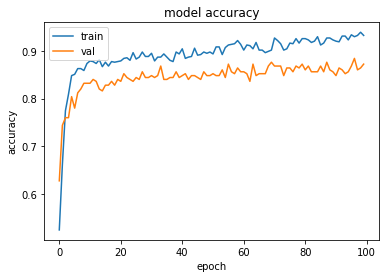

In [737]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

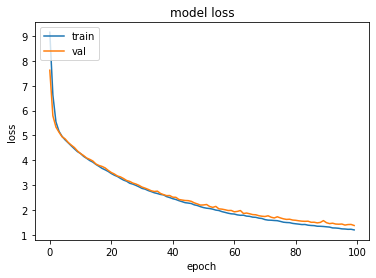

In [738]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Test

In [739]:
_, acc = cnn.evaluate(test_data, test_labels, verbose = False)

print('Accuracy = %.2f' % (acc*100) + '%')

Accuracy = 91.35%
